In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
using Random
using GraphPPL

import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [2]:
import ReactiveMP: @rule, @marginalrule, score

@rule(
    formtype => Type{ <: MvNormalMeanPrecision },
    on   => :μ,
    vconstraint => Marginalisation,
    messages => (m_out::ReactiveMP.FnWithApproximation, ),
    marginals => (q_Λ::Dirac, ),
    meta => Nothing,
    begin
        vin    = ReactiveMP.getinterface(__node, :μ)
        return vin.m_in |> take(1) |> map(MvNormalMeanPrecision, (m_μ) -> begin
            inv_q_Λ        = cholinv(mean(q_Λ))
            msg_fwd        = MvNormalMeanPrecision(mean(m_μ), cholinv(cov(m_μ) + inv_q_Λ))
            multiplication = getdata(as_message(msg_fwd) * as_message(m_out))
            
            m, c = mean(multiplication), cov(multiplication)
            return MvNormalMeanPrecision(m, cholinv(c + inv_q_Λ))
        end)
    end
)

@marginalrule(
    formtype => Type{ <: MvNormalMeanPrecision },
    on   => :out_μ,
    messages => (m_out::ReactiveMP.FnWithApproximation, m_μ::MvNormalMeanPrecision),
    marginals => (q_Λ::Dirac, ),
    meta => Nothing,
    begin
        d = ndims(m_μ)
        
        m_mean_mean, m_mean_cov = mean(m_μ), cov(m_μ)
        
        Wbar = mean(q_Λ)
        
        W = [ Wbar -Wbar; -Wbar Wbar ]

        logpdf = m_out.fn

        msg_fwd    = MvNormalMeanPrecision(mean(m_μ), cholinv(cov(m_μ) + cholinv(mean(q_Λ))))
        v_mean_inv = precision(m_μ)

        l(z) = @views -0.5 * z'*W*z - 0.5 * (z[d+1:end] - m_mean_mean)' * v_mean_inv * (z[d+1:end] - m_mean_mean) + logpdf(z[1:d])

        #Expansion point
        point1 = mean(as_message(msg_fwd) * as_message(m_out))

        try
            m_joint, v_joint = ForneyLab.NewtonMethod(l, [ point1; m_mean_mean ])
            return MvNormalMeanPrecision(m_joint, cholinv(v_joint))
        catch e
            # Use cubature as a fallback
            cubature = m_out.approximation
            mean, cov = ReactiveMP.approximate_meancov(cubature, (x) -> exp(logpdf(x)), msg_fwd)
            
            approx_prec = Matrix(Hermitian([ cholinv(cov) + Wbar -Wbar; -Wbar cholinv(m_mean_cov) + Wbar ]))
            approx_mean = cholinv(approx_prec) * [ cholinv(cov) * mean; cholinv(m_mean_cov) * m_mean_mean ]
            
            return MvNormalMeanPrecision(approx_mean, approx_prec)
        end
    end
)

function ReactiveMP.score(::AverageEnergy, ::Type{ <: KernelGCV }, marginal_names, marginals::Tuple{ <: Marginal{ <: MvNormalMeanPrecision }, <: Marginal{ <: MvNormalMeanPrecision } }, meta::KernelGCVMetadata)
    marg_out_mean = marginals[1]
    marg_z        = marginals[2]
    
    (m, V) = mean(marg_out_mean), cov(marg_out_mean)
    (mz,Vz) = mean(marg_z), cov(marg_z)

    d = Int64(ndims(marg_out_mean) / 2)

    cubature = ReactiveMP.get_approximation(meta)
    weights = ReactiveMP.getweights(cubature, mz, Vz)
    points  = ReactiveMP.getpoints(cubature, mz, Vz)
    
    kernelfn = ReactiveMP.get_kernelfn(meta)

    gs = Base.Generator(points) do point
        return kernelfn(point)
    end

    Λ_out = mapreduce(t -> t[1] * cholinv(t[2]), +, zip(weights, gs))
    log_det_sum = mapreduce(t -> t[1] * log(det(t[2])), +, zip(weights, gs))

    @views 0.5*d*log(2*pi) +
    0.5*log_det_sum +
    0.5*tr( Λ_out*( V[1:d,1:d] - V[1:d,d+1:end] - V[d+1:end,1:d] + V[d+1:end,d+1:end] + (m[1:d] - m[d+1:end])*(m[1:d] - m[d+1:end])' ) )
end

In [3]:
@model function multivariate_hgf_model(n, z_precision, kfunction, approximation, portals)
    
    zt = randomvar(n)
    xt = randomvar(n)
    yt = datavar(Vector{Float64}, n)
    
    # Priors
    zt_1_mean = datavar(Vector{Float64})
    zt_1_prec = datavar(Matrix{Float64})
    
    xt_1_mean = datavar(Vector{Float64})
    xt_1_prec = datavar(Matrix{Float64})
    
    y_prec_ν = datavar(Float64)
    y_prec_S = datavar(Matrix{Float64})
    
    zt_1_prior ~ MvNormalMeanPrecision(zt_1_mean, zt_1_prec)
    xt_1_prior ~ MvNormalMeanPrecision(xt_1_mean, xt_1_prec)
    y_prec_prior ~ Wishart(y_prec_ν, y_prec_S)
    
    zt_prev = zt_1_prior
    xt_prev = xt_1_prior
    
    zt_nodes = Vector{FactorNode}(undef, n)
    xt_nodes = Vector{FactorNode}(undef, n)
    yt_nodes = Vector{FactorNode}(undef, n)
    
    sync = PostponeScheduler()
    
    for i in 1:n
        portal = rem(i, portals) === 0 ? ScheduleOnPortal(sync) : EmptyPortal()
        
        zt_nodes[i], zt[i] ~ MvNormalMeanPrecision(zt_prev, z_precision) where { q = q(zt_prev, zt[i])q(z_precision), portal = portal }
        xt_nodes[i], xt[i] ~ KernelGCV(xt_prev, zt[i]) where { q = q(xt_prev, xt[i])q(zt[i]), meta = KernelGCVMetadata(kfunction, approximation), portal = portal }
        yt_nodes[i], yt[i] ~ MvNormalMeanPrecision(xt[i], y_prec_prior) where { q = MeanField() }
        
        zt_prev = zt[i]
        xt_prev = xt[i]
    end

    return sync, zt_1_mean, zt_1_prec, xt_1_mean, xt_1_prec, y_prec_ν, y_prec_S, y_prec_prior, zt, xt, yt, zt_nodes, xt_nodes, yt_nodes
end

multivariate_hgf_model (generic function with 1 method)

In [4]:
function inference(; data, iters, z_precision, kfunction, approximation, portals)
    n    = length(data)
    ndim = length(data[1])
    
    model, (sync, zt_1_mean, zt_1_prec, xt_1_mean, xt_1_prec, y_prec_ν, y_prec_S, y_prec_prior, zt, xt, yt, zt_nodes, xt_nodes, yt_nodes) = multivariate_hgf_model(n, z_precision, kfunction, approximation, portals)
    
    mz = Vector{Vector{Marginal}}()
    mx = Vector{Vector{Marginal}}()
    mV = Vector{Marginal}()
    
    m_scheduler = PendingScheduler()
    
    mz_sub = subscribe!(collectLatest(getmarginals(zt)) |> schedule_on(m_scheduler), (m) -> push!(mz, m))
    mx_sub = subscribe!(collectLatest(getmarginals(xt)) |> schedule_on(m_scheduler), (m) -> push!(mx, m))
    Vsub   = subscribe!(getmarginal(y_prec_prior), (V) -> push!(mV, V))
    
    wait(sync)
    
    # Initial marginals
    foreach(zt_nodes) do zt_node
        setmarginal!(zt_node, :out_μ, MvNormalMeanPrecision(zeros(2ndim), Matrix(Diagonal(1.0 * ones(2ndim)))))
    end
    
    foreach(xt_nodes) do xt_node
        setmarginal!(xt_node, :y_x, MvNormalMeanPrecision(zeros(2ndim), Matrix(Diagonal(1.0 * ones(2ndim)))))
        setmarginal!(xt_node, :z, MvNormalMeanPrecision(zeros(ndim), Matrix(Diagonal(1.0 * ones(ndim)))))
    end
    
    foreach(yt_nodes) do yt_node
        setmarginal!(yt_node, :μ, MvNormalMeanPrecision(zeros(ndim), Matrix(Diagonal(1.0 * ones(ndim)))))
    end
    
    setmarginal!(y_prec_prior, Wishart(ndim, 100.0 * Matrix(I, ndim, ndim)))
    
    # Initial messages
    prior_zt = MvNormalMeanPrecision(zeros(ndim), Matrix(Diagonal(100.0 * ones(ndim))))
    prior_xt = MvNormalMeanPrecision(zeros(ndim), Matrix(Diagonal(100.0 * ones(ndim))))
    prior_V  = Wishart(ndim, 100.0 * Matrix(I, ndim, ndim))
    
    fe = Vector{Float64}()
    fe_scheduler = PendingScheduler()
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (s) -> push!(fe, s))
    
    wait(sync)
    
    progress = ProgressMeter.Progress(iters)
    
    for _ in 1:iters
        
        update!(yt, data)
        update!(y_prec_ν, prior_V.df)
        update!(y_prec_S, Matrix(prior_V.S))
        update!(xt_1_mean, mean(prior_xt))
        update!(xt_1_prec, precision(prior_xt))
        update!(zt_1_mean, mean(prior_zt))
        update!(zt_1_prec, precision(prior_zt))
        
        wait(sync)    
        
        release!(m_scheduler)
        release!(fe_scheduler)
        
        ProgressMeter.next!(progress)
    end
    
    unsubscribe!(mz_sub)
    unsubscribe!(mx_sub)
    unsubscribe!(Vsub)
    unsubscribe!(fe_sub)
    
    return mz, mx, mV, fe
end

inference (generic function with 1 method)

In [5]:
using KernelFunctions

In [6]:
ndim     = 4

4

In [7]:
softplus(x) = log(1+exp(x))
logistic(x,L,x0) = L ./ (1 + exp(x-x0) )

logistic (generic function with 1 method)

In [8]:
kfunction = (d) -> kernelmatrix(LinearKernel(c = 2.0), d) + Diagonal(exp.(d))
# kfunction = (d) -> 0.01*(kernelmatrix(LinearKernel(c = 3.0), d) +  Diagonal(softplus.(d)))
# kfunction = (d) -> 0.01*(kernelmatrix(MaternKernel(), d) +  Diagonal(softplus.(d)))
# kfunction = (d) -> 0.01*(kernelmatrix(MaternKernel(), d) +  Diagonal(exp.(d)) + Diagonal(ones(ndim)))
# kfunction = (d) -> 0.01*(kernelmatrix(LinearKernel(c = 2.0), d) +  Diagonal(logistic.(d,10.0,5.0)))
# kfunction = (d) -> 0.01*(kernelmatrix(NeuralNetworkKernel(), d) +  Diagonal(logistic.(d,10.0,5.0)))
# kfunction = (d) -> 0.01*(kernelmatrix(CosineKernel(), d) +  Diagonal(logistic.(d,10.0,2.0)))
# kfunction = (d) -> 0.1*(kernelmatrix(SqExponentialKernel(), d) + 0.1*Diagonal(exp.(d)))

#32 (generic function with 1 method)

In [37]:
using Random
using Distributions
using LinearAlgebra

n     = 1000
ps    = 130
iters = 50

approximation = srcubature()
# approximation = laplace()
# approximation = ghcubature(3)

Random.seed!(2211)

z_prev = zeros(ndim)
x_prev = zeros(ndim)

z_covariance = Matrix(Diagonal(0.010 * ones(ndim)))
y_variance   = 0.001 * ones(ndim)
y_covariance = Matrix(Diagonal(y_variance))

z = Vector{Vector{Float64}}(undef, n)
v = Vector{Matrix{Float64}}(undef, n)
x = Vector{Vector{Float64}}(undef, n)
y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    z[i] = rand(MvNormal(z_prev, Matrix(z_covariance)))
    v[i] = kfunction(z[i])
    x[i] = rand(MvNormal(x_prev, v[i]))
    y[i] = rand(MvNormal(x[i], Matrix(y_covariance)))
    z_prev = z[i]
    x_prev = x[i]
end

In [38]:
mz, mx, mV, fe = inference(;
    data = y, 
    iters = iters, 
    z_precision = inv(z_covariance), 
    kfunction = kfunction, 
    approximation = approximation,
    portals = ps 
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


In [40]:
function plot_dimension(mz, mx, ys, dim = 1)
    p1 = plot(map(d -> d[dim], mean.(mz)), ribbon = map(d -> sqrt(d[dim]), var.(mz)), label = :z)
    p1 = plot!(p1, map(d -> d[dim], z), label = :real_z)

    p2 = plot(map(d -> d[dim], mean.(mx)), ribbon = map(d -> sqrt(d[dim]), var.(mx)), label = :x)
    p2 = plot!(p2, map(d -> d[dim], x), label = :real_x)
    p2 = scatter!(map(d -> d[dim], ys), ms = 2)
    
    plot(p1, p2, layout = (1, 2), size = (1200, 200), legend = false)
end

plot_dimension (generic function with 2 methods)

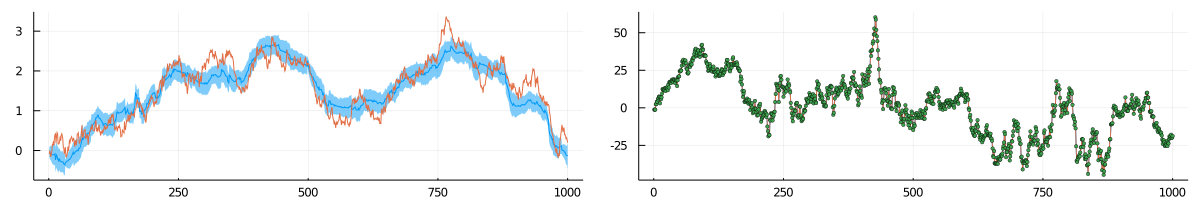

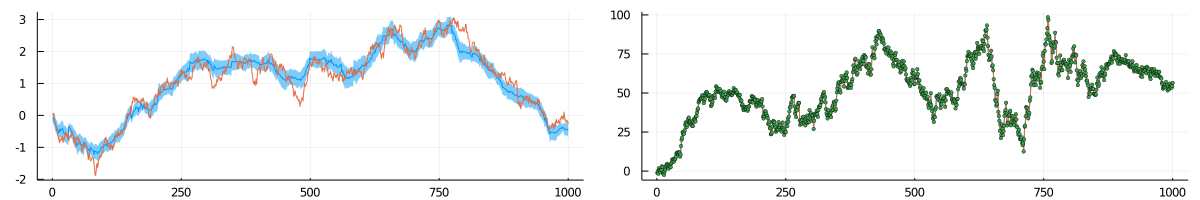

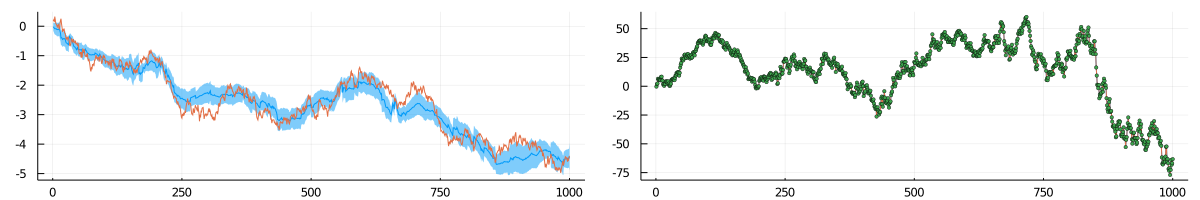

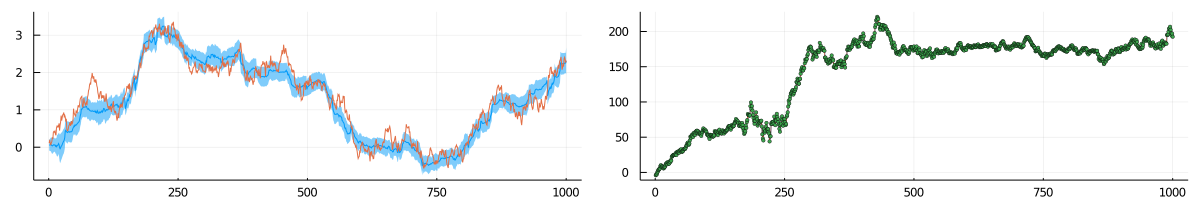

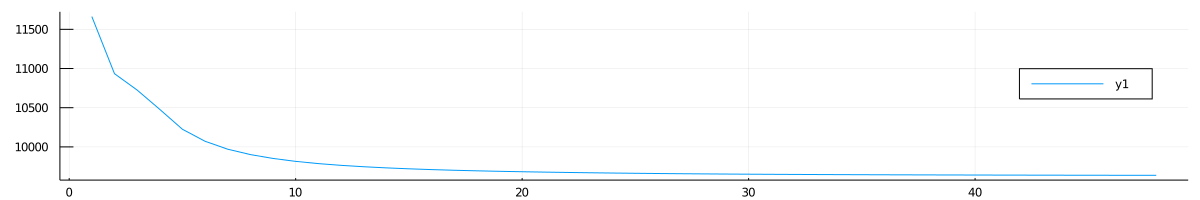

In [43]:
for i in 1:ndim
    display(plot_dimension(mz[end], mx[end], y, i))
end

display(plot(fe[3:end], size = (1200, 200)))

In [15]:
function expectationKernel(distribution,kernelfn)
    mz = mean(distribution)
    Vz = cov(distribution)
    cubature = srcubature()
    weights = ReactiveMP.getweights(cubature, mz, Vz)
    points  = ReactiveMP.getpoints(cubature, mz, Vz)
#     kernelfn = ReactiveMP.get_kernelfn(meta)
    gs = Base.Generator(points) do point
        return kernelfn(point)
    end
    Σ_out = mapreduce(t -> t[1] * t[2], +, zip(weights, gs)) 
end

expectationKernel (generic function with 1 method)

In [16]:
estimated_cov_matrices = map(z -> kfunction.(mean.(z)), mz);

In [17]:
estimated_cov_matrices;